In [8]:
"""
Clean your text to create normalized text represenations.
"""

import logging
import re
import sys
from unicodedata import category

from emoji import UNICODE_EMOJI, demojize, emojize
from ftfy import fix_text

from cleantext import constants
from cleantext.specials import save_replace
from cleantext.utils import remove_substrings

log = logging.getLogger()

# fall back to `unicodedata`
try:
    from unidecode import unidecode

except ImportError:
    from unicodedata import normalize

    unidecode = lambda x: normalize("NFD", x).encode("ASCII", "ignore").decode("utf-8")
    log.warning(
        "Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results."
    )


def fix_strange_quotes(text):
    """
    Replace strange quotes, i.e., 〞with a single quote ' or a double quote " if it fits better.
    """
    text = constants.SINGLE_QUOTE_REGEX.sub("'", text)
    text = constants.DOUBLE_QUOTE_REGEX.sub('"', text)
    return text


def fix_bad_unicode(text, normalization="NFC"):
    """
    Fix unicode text that's "broken" using `ftfy <http://ftfy.readthedocs.org/>`_;
    this includes mojibake, HTML entities and other code cruft,
    and non-standard forms for display purposes.
    Args:
        text (str): raw text
        normalization ({'NFC', 'NFKC', 'NFD', 'NFKD'}): if 'NFC',
            combines characters and diacritics written using separate code points,
            e.g. converting "e" plus an acute accent modifier into "é"; unicode
            can be converted to NFC form without any change in its meaning!
            if 'NFKC', additional normalizations are applied that can change
            the meanings of characters, e.g. ellipsis characters will be replaced
            with three periods
    """
    # trying to fix backslash-replaced strings (via https://stackoverflow.com/a/57192592/4028896)
    try:
        text = text.encode("latin", "backslashreplace").decode("unicode-escape")
    except:
        pass

    return fix_text(text, normalization=normalization)


def to_ascii_unicode(text, lang="en", no_emoji=False):
    """
    Try to represent unicode data in ascii characters similar to what a human
    with a US keyboard would choose.
    Works great for languages of Western origin, worse the farther the language
    gets from Latin-based alphabets. It's based on hand-tuned character mappings
    that also contain ascii approximations for symbols and non-Latin alphabets.
    """
    # normalize quotes before since this improves transliteration quality
    text = fix_strange_quotes(text)

    if not no_emoji:
        text = demojize(text, use_aliases=True)

    lang = lang.lower()
    # special handling for German text to preserve umlauts
    if lang == "de":
        text = save_replace(text, lang=lang)

    text = unidecode(text)

    # important to remove utility characters
    if lang == "de":
        text = save_replace(text, lang=lang, back=True)

    if not no_emoji:
        text = emojize(text, use_aliases=True)

    return text


def normalize_whitespace(
    text, no_line_breaks=False, strip_lines=True, keep_two_line_breaks=False
):
    """
    Given ``text`` str, replace one or more spacings with a single space, and one
    or more line breaks with a single newline. Also strip leading/trailing whitespace.
    """
    if strip_lines:
        text = "\n".join([x.strip() for x in text.splitlines()])

    if no_line_breaks:
        text = constants.MULTI_WHITESPACE_TO_ONE_REGEX.sub(" ", text)
    else:
        if keep_two_line_breaks:
            text = constants.NONBREAKING_SPACE_REGEX.sub(
                " ", constants.TWO_LINEBREAK_REGEX.sub(r"\n\n", text)
            )
        else:
            text = constants.NONBREAKING_SPACE_REGEX.sub(
                " ", constants.LINEBREAK_REGEX.sub(r"\n", text)
            )

    return text.strip()


# used below to keep `normalize_whitespace` as a parameter in `clean`
def _normalize_whitespace(*kwargs):
    return normalize_whitespace(*kwargs)


def replace_urls(text, replace_with="<URL>"):
    """
    Replace all URLs in ``text`` str with ``replace_with`` str.
    """
    return constants.URL_REGEX.sub(replace_with, text)


def replace_emails(text, replace_with="<EMAIL>"):
    """
    Replace all emails in ``text`` str with ``replace_with`` str.
    """
    return constants.EMAIL_REGEX.sub(replace_with, text)


def replace_phone_numbers(text, replace_with="<PHONE>"):
    """
    Replace all phone numbers in ``text`` str with ``replace_with`` str.
    """
    return constants.PHONE_REGEX.sub(replace_with, text)


def replace_numbers(text, replace_with="<NUMBER>"):
    """
    Replace all numbers in ``text`` str with ``replace_with`` str.
    """
    return constants.NUMBERS_REGEX.sub(replace_with, text)


def replace_digits(text, replace_with="0"):
    """
    Replace all digits in ``text`` str with ``replace_with`` str, i.e., 123.34 to 000.00
    """
    return re.sub(r"\d", replace_with, text)


def replace_currency_symbols(text, replace_with="<CUR>"):
    """
    Replace all currency symbols in ``text`` str with string specified by ``replace_with`` str.
    Args:
        text (str): raw text
        replace_with (str): if None (default), replace symbols with
            their standard 3-letter abbreviations (e.g. '$' with 'USD', '£' with 'GBP');
            otherwise, pass in a string with which to replace all symbols
            (e.g. "*CURRENCY*")
    """
    if replace_with is None:
        for k, v in constants.CURRENCIES.items():
            text = text.replace(k, v)
        return text
    else:
        return constants.CURRENCY_REGEX.sub(replace_with, text)


def replace_punct(text, replace_with=" "):
    """
    Replace punctuations from ``text`` with whitespaces (or other tokens).
    """
    return text.translate(
        dict.fromkeys(
            (i for i in range(sys.maxunicode) if category(chr(i)).startswith("P")),
            replace_with,
        )
    )


def remove_punct(text):
    """
    Remove punctuations from ``text``.
    """
    return text.translate(constants.PUNCT_TRANSLATE_UNICODE)


def remove_emoji(text):
    return remove_substrings(text, UNICODE_EMOJI["en"])


def clean(
    text,
    fix_unicode=True,
    to_ascii=True,
    lower=True,
    normalize_whitespace=True,
    no_line_breaks=False,
    strip_lines=True,
    keep_two_line_breaks=False,
    no_urls=False,
    no_emails=False,
    no_phone_numbers=False,
    no_numbers=False,
    no_digits=False,
    no_currency_symbols=False,
    no_punct=False,
    no_emoji=False,
    replace_with_url="<URL>",
    replace_with_email="<EMAIL>",
    replace_with_phone_number="<PHONE>",
    replace_with_number="<NUMBER>",
    replace_with_digit="0",
    replace_with_currency_symbol="<CUR>",
    replace_with_punct="",
    lang="en",
):
    """
    Normalize various aspects of a raw text. A convenience function for applying all other preprocessing functions in one go.
    Args:
        text (str): raw text to preprocess
        fix_unicode (bool): if True, fix "broken" unicode such as
            mojibake and garbled HTML entities
        to_ascii (bool): if True, convert non-to_ascii characters
            into their closest to_ascii equivalents
        lower (bool): if True, all text is lower-cased
        no_line_breaks (bool): if True, strip line breaks from text
        no_urls (bool): if True, replace all URL strings with a special URL token
        no_emails (bool): if True, replace all email strings with a special EMAIL token
        no_phone_numbers (bool): if True, replace all phone number strings
            with a special PHONE token
        no_numbers (bool): if True, replace all number-like strings
            with a special NUMBER token
        no_digits (bool): if True, replace all digits with a special DIGIT token
        no_currency_symbols (bool): if True, replace all currency symbols
            with a special CURRENCY token
        no_punct (bool): if True, remove all punctuation (replace with
            empty string)
        replace_with_url (str): special URL token, default "<URL>",
        replace_with_email (str): special EMAIL token, default "<EMAIL>",
        replace_with_phone_number (str): special PHONE token, default "<PHONE>",
        replace_with_number (str): special NUMBER token, default "<NUMBER>",
        replace_with_digit (str): special DIGIT token, default "0",
        replace_with_currency_symbol (str): special CURRENCY token, default "<CUR>",
        replace_with_punct (str): replace punctuations with this token, default "",
        lang (str): special language-depended preprocessing. Besides the default English ('en'), only German ('de') is supported

    Returns:
        str: input ``text`` processed according to function args
    """

    if text is None:
        return ""

    text = str(text)

    if fix_unicode:
        text = fix_bad_unicode(text)
    if no_currency_symbols:
        text = replace_currency_symbols(text, replace_with_currency_symbol)
    if to_ascii:
        text = to_ascii_unicode(text, lang=lang, no_emoji=no_emoji)
    if no_urls:
        text = replace_urls(text, replace_with_url)
    if no_emails:
        text = replace_emails(text, replace_with_email)
    if no_phone_numbers:
        text = replace_phone_numbers(text, replace_with_phone_number)
    if no_numbers:
        text = replace_numbers(text, replace_with_number)
    if no_digits:
        text = replace_digits(text, replace_with_digit)
    if no_punct:
        if replace_with_punct == "":
            text = remove_punct(text)
        else:
            text = replace_punct(text, replace_with_punct)

    if no_emoji and not to_ascii:
        text = remove_emoji(text)

    if lower:
        text = text.lower()

    if normalize_whitespace:
        text = _normalize_whitespace(
            text, no_line_breaks, strip_lines, keep_two_line_breaks
        )

    return text


In [9]:
def mycleaner(text):
    text = fix_strange_quotes(text)
    text = fix_bad_unicode(text)
    text = replace_currency_symbols(text)
    text = replace_urls(text)
    text = replace_emails(text)
    text = replace_phone_numbers(text)
    text = replace_numbers(text)
    text = replace_digits(text)
    text = remove_emoji(text)
    text = _normalize_whitespace(text)
    return text

In [10]:
max_words = 150000
max_sentences = 20
max_word_per_sen = 50

In [11]:
import os
a = os.listdir('data')
import json
X = []
y = []
for i in a:
    with open(f'data/{i}', encoding='utf8') as f:
        json_file = json.load(f)
    # for j in range(len(json_file)): read all
    # 1757
    for j in range(1757):
    # for j in range(len(json_file)):
        X.append(json_file[j]['message'])
        y.append(i)

In [12]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_encoder = le.fit_transform(y)
from sklearn.preprocessing import OneHotEncoder
import numpy as np
oh = OneHotEncoder()
classes_indices = list(zip(le.classes_, np.arange(len(le.classes_))))
words_indices = list(zip(y, y_encoder))
one_hot = oh.fit_transform(words_indices).toarray()
print(type(one_hot))
# print('\n')
# print(oh.inverse_transform(one_hot))
y_final = np.array([one_hot[i][0:15] for i in range(len(y))])

<class 'numpy.ndarray'>


In [13]:
texts = []
sentences = []
for i in range(len(X)):
    text = X[i]
    texts.append(text)
    sentence = text.split(' . ')
    sentences.append(sentence)

In [ ]:
texts_clean = []
for i in texts:
    texts_clean.append(mycleaner(i))

In [14]:
import pickle
pickle.dump(texts_clean, open('texts_clean.pkl', 'wb'))

In [14]:
import pickle
texts_clean = pickle.load(open('texts_clean.pkl','rb'))

In [61]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~', lower=False)
tokenizer.fit_on_texts(texts_clean)
word_index = tokenizer.word_index

In [74]:
import pickle
pickle.dump(word_index, open('word_index.pkl', 'wb'))

In [15]:
import pickle
word_index = pickle.load(open('word_index.pkl','rb'))

In [16]:
from itertools import islice
def take(n, iterable):
    # Return first n items of the iterable as a list
    return list(islice(iterable, n))
print(word_index['tập_trung'])
print(len(word_index))
print(list(word_index.keys())[list(word_index.values()).index(7500)]) 
print(take(10, word_index.items()))

277
150341
VT
[('NUMBER', 1), ('và', 2), ('của', 3), ('các', 4), ('là', 5), ('có', 6), ('được', 7), ('trong', 8), ('cho', 9), ('đã', 10)]


In [ ]:
# import numpy as np
# word2vec = {}
# f = open('D:/NLP_TASK/general_data/word2vec_vi_words_300dims.txt', encoding='utf8')
# for line in f:
#     try:
#         values = line.split()
#         word = values[0]
#         coefs = np.asarray(values[1:], dtype='float32')
#         word2vec[word] = coefs   
#     except Exception:
#         print(line[:50])
#         pass
# f.close()

In [21]:
# import pickle 
# pickle.dump(word2vec, open('word2vec.pkl', 'wb'))

In [17]:
import pickle
word2vec = pickle.load(open('word2vec.pkl','rb'))

In [18]:
len(word2vec)

1585091

In [ ]:
sentences_clean = []
for i in sentences:
    tmp = []
    for j in i:
        tmp.append(mycleaner(j))
    sentences_clean.append(tmp)

In [25]:
import pickle
pickle.dump(sentences_clean, open('sentences_clean.pkl', 'wb'))

In [20]:
import pickle
sentences_clean = pickle.load(open('sentences_clean.pkl','rb'))

In [21]:
from keras.preprocessing.text import text_to_word_sequence

In [22]:
sentence_number = []
word_number = []
for i in sentences_clean:
    sentence_number.append(len(i))
    for j in i:
        word_number.append(len(text_to_word_sequence(j, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~', lower=False)))

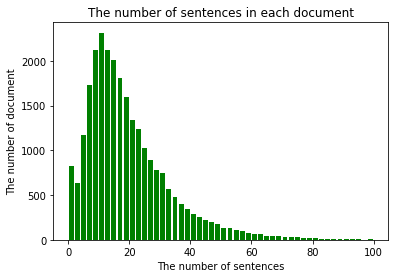

In [28]:
import matplotlib.pyplot as plt
# frequencies
# ages = [2,5,70,40,30,45,50,45,43,40,44,60,7,13,57,18,90,77,32,21,20,40]
# setting the ranges and no. of intervals
range = (0, 100)
bins = 50  
# plotting a histogram
plt.hist(sentence_number, bins, range, color = 'green',
        histtype = 'bar', rwidth = 0.8)
# x-axis label
plt.xlabel('The number of sentences')
# frequency label
plt.ylabel('The number of document')
# plot title
plt.title('The number of sentences in each document')
# function to show the plot
plt.show()

In [6]:
import numpy as np

In [11]:
data = np.zeros((len(texts_clean), max_sentences, max_word_per_sen), dtype='int32')
for i, sentence in enumerate(sentences_clean):
    for j, sen in enumerate(sentence):
        if j < max_sentences:
            word_tokens = text_to_word_sequence(sen, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~', lower=False)
            k = 0
            for _, word in enumerate(word_tokens):
                if k < max_word_per_sen and word in word_index and word_index[word] < max_words:
                    data[i, j, k] = word_index[word]
                    k += 1

In [12]:
data.shape

(26355, 25, 50)

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y_final, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

In [18]:
import keras 
import tensorflow as tf
from tensorflow import keras
import re
import numpy as np
import pandas as pd
from keras import backend as K
from keras.models import Model
from keras import initializers
from keras.layers import Layer
from keras.layers import Dense, Input
from keras.layers import Embedding, GRU, Bidirectional, TimeDistributed
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils.np_utils import to_categorical
from nltk import tokenize

In [68]:
class HierarchicalAttentionNetwork(keras.layers.Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.attention_dim = attention_dim
        super(HierarchicalAttentionNetwork, self).__init__()
    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init((self.attention_dim,)))
        self.u = K.variable(self.init((self.attention_dim, 1)))
        self._trainable_weights = [self.W, self.b, self.u]
        super(HierarchicalAttentionNetwork, self).build(input_shape)
    def call(self, hit):
        # size of hit :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(w.hit+b)
        uit = K.tanh(K.bias_add(K.dot(hit, self.W), self.b))
        # ait = exp(uit*u) / sum(exp(uit*u))
        ait = K.exp(K.squeeze(K.dot(uit, self.u), -1))
        ait /= K.cast(K.sum(ait, 1, True) + K.epsilon(), K.floatx())
        # si = sum(ait*hit)
        weighted_input = hit * K.expand_dims(ait)
        output = K.sum(weighted_input, 1)
        return output
    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [19]:
embedding_dim = 300

In [70]:
# Building Hierachical Attention network
embedding_matrix = np.random.random((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix],
                            input_length=max_word_per_sen, trainable=True)

sentence_input = Input(shape=(max_word_per_sen,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
bigru_word = Bidirectional(GRU(100, return_sequences=True))(embedded_sequences)
attn_word = HierarchicalAttentionNetwork(100)(bigru_word)
sentenceEncoder = Model(sentence_input, attn_word)

document_input = Input(shape=(max_sentences, max_word_per_sen), dtype='int32')
document_encoder = TimeDistributed(sentenceEncoder)(document_input)
bigru_sentence = Bidirectional(GRU(100, return_sequences=True))(document_encoder)
attn_sentence = HierarchicalAttentionNetwork(100)(bigru_sentence)
preds = Dense(15, activation='softmax')(attn_sentence)
model = Model(document_input, preds)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [71]:
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5, batch_size=32)

Epoch 1/5
593/593 [==============================] - 1408s 2s/step - loss: 1.2557 - acc: 0.6010 - val_loss: 0.8647 - val_acc: 0.7278
Epoch 2/5
593/593 [==============================] - 1711s 3s/step - loss: 0.5134 - acc: 0.8321 - val_loss: 0.7822 - val_acc: 0.7544
Epoch 3/5
593/593 [==============================] - 1417s 2s/step - loss: 0.2078 - acc: 0.9300 - val_loss: 0.9045 - val_acc: 0.7477
Epoch 4/5
593/593 [==============================] - 1426s 2s/step - loss: 0.1058 - acc: 0.9623 - val_loss: 1.0244 - val_acc: 0.7501
Epoch 5/5
593/593 [==============================] - 1435s 2s/step - loss: 0.0771 - acc: 0.9700 - val_loss: 1.1228 - val_acc: 0.7402


In [72]:
model.save('D:/NLP_TASK/3_heirarchical_attention_networks')

INFO:tensorflow:Assets written to: D:/NLP_TASK/3_heirarchical_attention_networks\assets


INFO:tensorflow:Assets written to: D:/NLP_TASK/3_heirarchical_attention_networks\assets


In [21]:
import keras

In [22]:
model = keras.models.load_model('D:/NLP_TASK/3_heirarchical_attention_networks')

In [23]:
y_pred = model.predict(X_test)

165/165 [==============================] - 104s 616ms/step


In [24]:
y_pred_ = []
for i in y_pred:
    idx = np.where(i == np.amax(i))
    y_pred_.append(idx[0][0])

In [25]:
y_test_ = []
for i in y_test:
    for j in range(15):
        if i[j] == 1.0:
            y_test_.append(j)

In [26]:
from sklearn.metrics import f1_score
f1_score(y_test_, y_pred_, average = None)

array([0.94385027, 0.91860465, 0.89189189, 0.9683908 , 0.92753623,
       0.75881523, 0.92625369, 0.92493298, 0.93181818, 0.90237467,
       0.92834891, 0.98461538, 0.96978417, 0.76773296, 0.87209302])

In [27]:
from sklearn.metrics import f1_score
f1_score = pd.DataFrame(f1_score(y_test_, y_pred_, average = None))
print(f1_score)

           0
0   0.943850
1   0.918605
2   0.891892
3   0.968391
4   0.927536
5   0.758815
6   0.926254
7   0.924933
8   0.931818
9   0.902375
10  0.928349
11  0.984615
12  0.969784
13  0.767733
14  0.872093


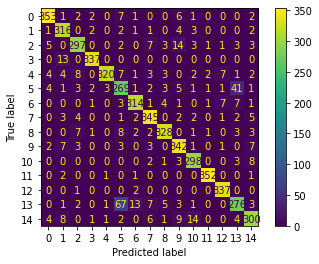

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp=ConfusionMatrixDisplay(confusion_matrix(y_test_, y_pred_))

disp.plot()
plt.show()